In [3]:
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
import datetime as dt
import dill
# Check current directory
import os
print(os.getcwd())

/Users/sethblum/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/Courses/1C51/project-repo/FinalProject_1.C01


In [148]:
# Inactive - need to integrate other code


# modelpath = 'Model_Outputs/model_BiLSTM_3layers_2024-05-06 11:48:50.924766.keras'
# model = load_model(modelpath)
predspath = 'Model_Outputs/predictions_BiLSTM_3layers_2024-05-14_13-00-24.csv'
preddf = pd.read_csv(predspath)

data = pd.read_pickle('X_test.pkl')
Xscaler = pd.read_pickle('Xscaler.pkl')

In [149]:
# data = pd.DataFrame(Xscaler.inverse_transform(data[:,0:4]))
# DAM = data[0]
# preddf['DAM'] = DAM

# # Note - day ahead is hardcoded as which column so be careful if changed

In [150]:
cleandf = pd.read_pickle('Data_Clean/merged_clean_df.pkl')


In [151]:
test = np.arange(0, 100, 1)
testseq = np.array_split(test, 5)
[testseq[i] for i in range(5) if i % 2 == 0]


[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59]),
 array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96,
        97, 98, 99])]

In [152]:
import numpy as np

# Convert preddf to numpy array
preddf_array = preddf.to_numpy()

# Split preddf_array into sequences of length 96
sequences = np.array_split(preddf_array, len(preddf)//96)

# # Keepevery 96th sequence
sequences_mod96 = [sequences[i] for i in range(len(sequences)) if i % 96 == 0]

# # Convert sequences_mod96 to dataframe
preddf_mod96 = pd.DataFrame(np.concatenate(sequences_mod96, axis=0), columns=preddf.columns)

In [153]:
preddf = preddf_mod96

In [162]:
preddf['Actual'].value_counts()

Actual
18.00     73
17.02     71
17.17     70
16.90     70
17.21     70
          ..
116.66     1
111.81     1
146.97     1
91.73      1
6.45       1
Name: count, Length: 6557, dtype: int64

In [155]:
v = 146.97
cleandf['i'] = range(0, len(cleandf))
#preddf.drop(columns=['Unnamed: 0'], inplace=True)
i_pred = preddf[(preddf['Actual'] >= v - .005) & (preddf['Actual'] <= v + .005)]
i_clean = cleandf[(cleandf['RTM'] >= v - .005) & (cleandf['RTM'] <= v + .005)]['i'].values[0]
i_pred_indices = i_pred.index.tolist()[0]
d = i_clean - i_pred_indices

matchingdf = cleandf.iloc[d-3:]


In [156]:
preddf.head(15)

,Unnamed: 0,Actual,Predicted
0,0.0,15.30,24.793380
1,1.0,15.33,27.707119
2,2.0,15.01,29.172842
3,3.0,14.59,30.161665
4,4.0,14.42,31.069470
5,5.0,13.65,31.568684
6,6.0,13.66,31.318400
7,7.0,13.60,31.734620
8,8.0,13.77,32.964657
9,9.0,13.78,35.221880


In [157]:
preddf['Predicted']

0        24.793380
1        27.707119
2        29.172842
3        30.161665
4        31.069470
           ...    
56539    25.081133
56540    26.482765
56541    27.954062
56542    29.184713
56543    29.314917
Name: Predicted, Length: 56544, dtype: float64

In [161]:
matchingdf[:len(preddf)].tail(15)

,DAM,RTM,load_fc,load_diff,Day,Month,Year,Hour,Minute,i
dt,,,,,,,,,,
2020-09-24 05:00:00,11.91,12.30,9286.89,-388.176422,3.0,9.0,2020.0,5.0,0.0,306263
2020-09-24 05:15:00,12.58,12.67,9567.01,-283.315197,3.0,9.0,2020.0,5.0,15.0,306264
2020-09-24 05:30:00,12.58,12.73,9567.01,-283.315197,3.0,9.0,2020.0,5.0,30.0,306265
2020-09-24 05:45:00,12.58,12.94,9567.01,-283.315197,3.0,9.0,2020.0,5.0,45.0,306266
2020-09-24 06:00:00,12.58,13.37,9567.01,-283.315197,3.0,9.0,2020.0,6.0,0.0,306267
2020-09-24 06:15:00,14.54,15.68,10081.15,-193.913204,3.0,9.0,2020.0,6.0,15.0,306268
2020-09-24 06:30:00,14.54,15.39,10081.15,-193.913204,3.0,9.0,2020.0,6.0,30.0,306269
2020-09-24 06:45:00,14.54,15.34,10081.15,-193.913204,3.0,9.0,2020.0,6.0,45.0,306270
2020-09-24 07:00:00,14.54,15.30,10081.15,-193.913204,3.0,9.0,2020.0,7.0,0.0,306271


In [159]:
preddf.tail(15)

,Unnamed: 0,Actual,Predicted
56529,5419089.0,15.39,22.326118
56530,5419090.0,15.34,22.706133
56531,5419091.0,15.30,22.791645
56532,5419092.0,15.30,21.677347
56533,5419093.0,15.29,21.109426
56534,5419094.0,15.24,20.999073
56535,5419095.0,15.32,21.502628
56536,5419096.0,15.32,22.214030
56537,5419097.0,15.32,22.977003
56538,5419098.0,15.29,23.860352


In [160]:
cleandf.iloc[]

SyntaxError: invalid syntax (4007806316.py, line 1)

In [ ]:
cleandf[(cleandf['RTM'] >= preddf['Actual'].iloc[0]-.01) & (cleandf['RTM'] <= preddf['Actual'].iloc[0]+.01)]

,DAM,RTM,load_fc,load_diff,Day,Month,Year,Hour,Minute
dt,,,,,,,,,
2012-01-19 01:00:00,15.54,15.30,0.00,0.000000,3.0,1.0,2012.0,1.0,0.0
2012-01-20 00:00:00,18.19,15.31,0.00,0.000000,4.0,1.0,2012.0,0.0,0.0
2012-01-24 04:30:00,15.68,15.31,0.00,0.000000,1.0,1.0,2012.0,4.0,30.0
2012-01-25 03:00:00,15.23,15.31,0.00,0.000000,2.0,1.0,2012.0,3.0,0.0
2012-01-30 02:45:00,16.60,15.30,0.00,0.000000,0.0,1.0,2012.0,2.0,45.0
...,...,...,...,...,...,...,...,...,...
2023-11-20 21:00:00,21.33,15.30,12486.35,-274.424732,0.0,11.0,2023.0,21.0,0.0
2023-11-28 23:15:00,19.54,15.30,10932.66,175.387361,1.0,11.0,2023.0,23.0,15.0
2023-12-08 20:45:00,20.70,15.30,0.00,0.000000,4.0,12.0,2023.0,20.0,45.0


In [ ]:
# scalerX = dill.load(open('Xscaler.pkl', 'rb'))
# scalerY = dill.load(open('Yscaler.pkl', 'rb'))
# # Load the data
# X_train_encoded = dill.load(open('X_train_encoded.pkl', 'rb'))
# X_test_encoded = dill.load(open('X_test_encoded.pkl', 'rb'))
# y_train_encoded = dill.load(open('y_train_encoded.pkl', 'rb'))
# y_test_encoded = dill.load(open('y_test_encoded.pkl', 'rb'))
# # TODO need to add
# y_test_notscaled = dill.load(open('raw_y_test.pkl', 'rb'))

In [ ]:
# Define function to compare and plot model predictions from actual values
# Allow to zoom into a certain interval on the x axis

def plot_comparison(predictions, actual, DAM = None, startx=None, endx=None, starty=None, endy=None):
    """
    Plot the predicted vs actual values with an optional x-axis limit.

    Parameters:
        predictions (array-like): The predicted values.
        actual (array-like): The actual values.
        start (int, optional): Start index for x-axis limit.
        end (int, optional): End index for x-axis limit.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(predictions, label='Predicted')  # Added markers for better visibility
    plt.plot(actual, label='Actual')  # Added markers for better visibility
    if DAM is not None:
        plt.plot(DAM, label='DAM')
    plt.legend()
    
    # Set x-axis limits if specified
    if startx is not None or endx is not None:
        plt.xlim(startx, endx)
        plt.ylim(preddf['Actual'][startx:endx].min(), preddf['Actual'][startx:endx].max())
        
    # Set y-axis limits if specified
    if starty is not None or endy is not None:
        plt.ylim(starty, endy)    
    
    plt.title('Comparison of Predictions and Actual Values ('+predspath[41:57]+')')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

    
    # Plot the differences between the actual value and the predicted value
    plt.figure(figsize=(12, 6))
    
    # Set x-axis limits if specified
    if startx is not None or endx is not None:
        plt.xlim(startx, endx)
        
    # Set y-axis limits if specified
    if starty is not None or endy is not None:
        plt.ylim(starty, endy)    
    
    plt.plot(predictions - actual, label='Difference')
    plt.legend()
    print('everything but show')
    plt.show()
    print('done')
    return
    

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mse = mean_squared_error(preddf['Actual'], preddf['Predicted'])
print('mse'+str(mse/len(preddf['Actual'])))

mae = mean_absolute_error(preddf['Actual'], preddf['Predicted'])
print('mae'+str(mae / len(preddf['Actual'])))


mse0.6554431934512815
mae0.0003891231640847784


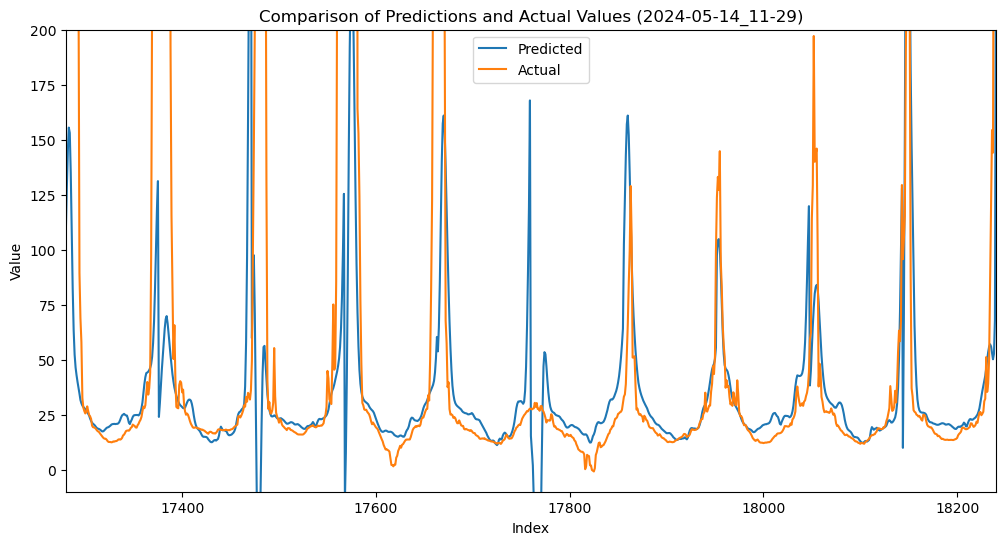

everything but show


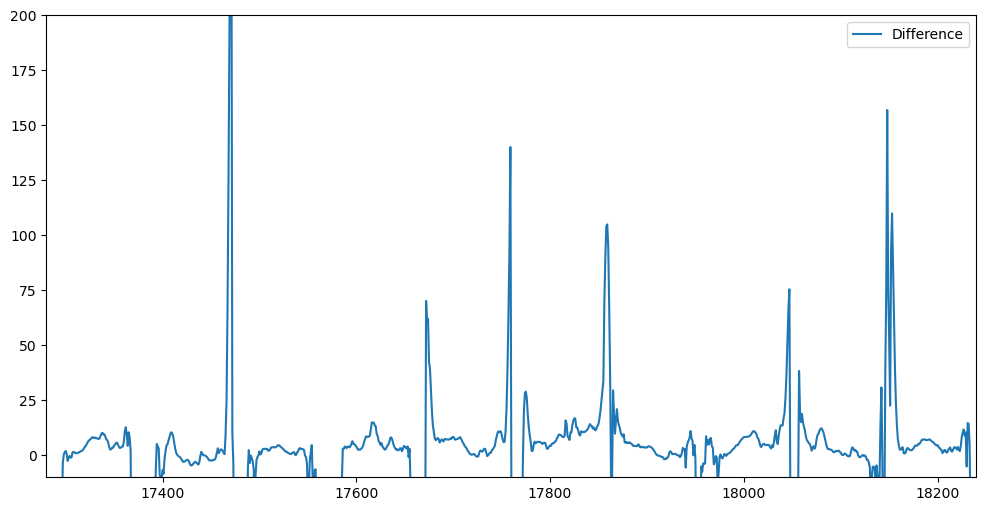

done


In [ ]:
plot_comparison(preddf['Predicted'], preddf['Actual'], startx=96*180, endx=0+96*190, starty=-10, endy=200)

In [ ]:

def get_category(value):
    if value >= 25:
        return 3
    elif value >= 0:
        return 2
    elif value >= -25:
        return 1
    else:
        return 0

preddf['Actual Category'] = (preddf['Actual']-preddf['DAM']).apply(get_category)
preddf['Predicted Category'] = (preddf['Predicted']-preddf['DAM']).apply(get_category)

In [ ]:
preddf['CatAccuracy'] = preddf['Actual Category'] == preddf['Predicted Category']

In [ ]:
preddf['CatAccuracy']

0         True
1         True
2         True
3         True
4        False
         ...  
55815     True
55816     True
55817     True
55818     True
55819     True
Name: CatAccuracy, Length: 55820, dtype: bool

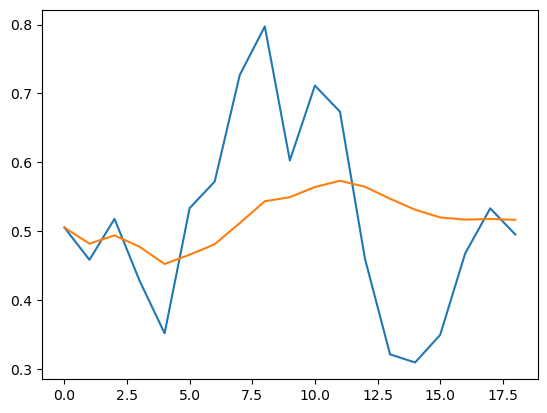

In [ ]:
catdays = []
runningcatdays = []
for i in range(1,len(preddf['CatAccuracy'])):
    if i % (96*30) == 0:
        catdays.append(preddf['CatAccuracy'][i:i+96*30].sum()/len(preddf[i:i+96*30]))
        runningcatdays.append(sum(catdays)/len(catdays))


plt.plot(catdays)
plt.plot(runningcatdays)
plt.show()

In [ ]:
signdiff = np.sign(preddf['Predicted']-preddf['DAM']) == np.sign(preddf['Actual']-preddf['DAM'])

preddf

signdays = []
for i in range(1,len(signdiff)):
    if i % (96* 30) == 0:
        signdays.append(signdiff[i:i+96 * 30].sum()/len(signdiff[i:i+96 * 30]))

In [ ]:
print(signdiff.sum()/len(signdiff))

0.7644213543532784


/Users/sethblum/anaconda3/envs/joint1c51/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sethblum/anaconda3/envs/joint1c51/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


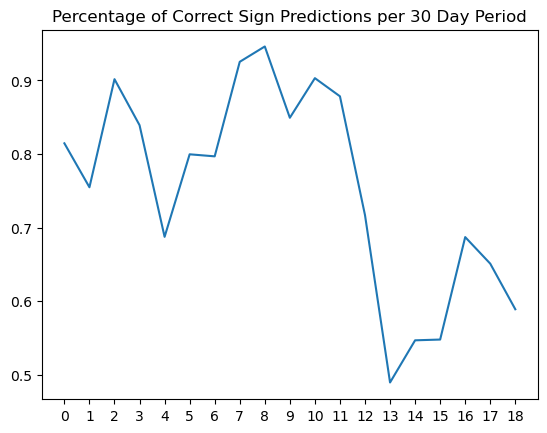

/Users/sethblum/anaconda3/envs/joint1c51/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

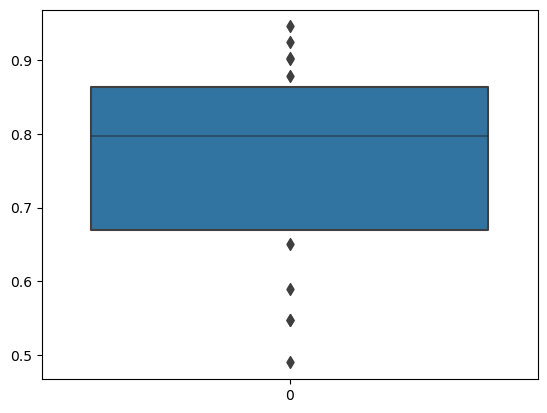

In [ ]:
sns.lineplot(x=range(len(signdays)), y=signdays)
plt.title('Percentage of Correct Sign Predictions per 30 Day Period')

# Set the x-axis tick values to integer values
plt.xticks(range(len(signdays)), range(len(signdays)))

plt.show()
sns.boxenplot(signdays)

In [ ]:
(np.sign(preddf['Predicted']-preddf['DAM'])).sum()/len(preddf)

0.0853099247581512